# Cluster Interpretation: Mental Health in Tech 2016

## 1. Load Data

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

RUN = 'run_03'

df = pd.read_csv(f'../../data/{RUN}/clustered/clustered_data.csv')

## 2. Cluster Overview

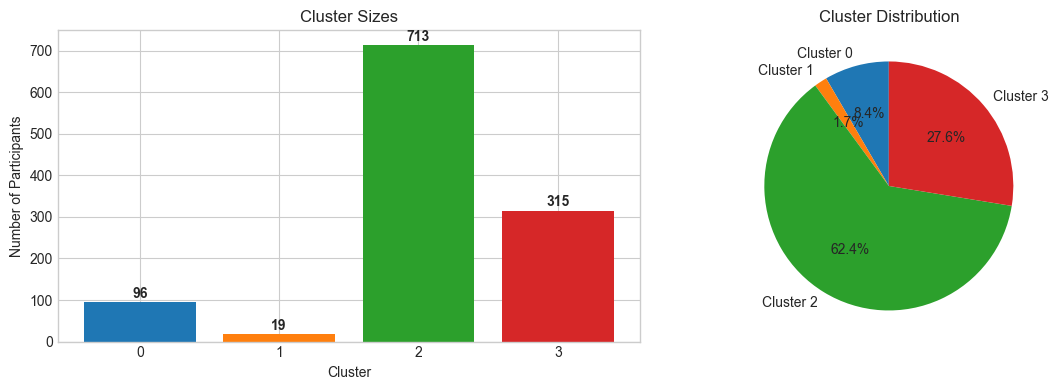

In [12]:
cluster_counts = df['cluster'].value_counts().sort_index()
n_clusters = len(cluster_counts)

cluster_names = {
    0: 'Cluster 0',
    1: 'Cluster 1',
    2: 'Cluster 2',
    3: 'Cluster 3'
}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = plt.cm.tab10(range(n_clusters))

axes[0].bar(cluster_counts.index, cluster_counts.values, color=colors)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Number of Participants')
axes[0].set_title('Cluster Sizes')
axes[0].set_xticks(cluster_counts.index)
for i, v in enumerate(cluster_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

axes[1].pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index],
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Cluster Distribution')

plt.tight_layout()
os.makedirs(f'../../plots/{RUN}', exist_ok=True)
plt.savefig(f'../../plots/{RUN}/cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Composite Indices Analysis (NEW in run_03)

Composite indices found: ['idx_mental_health_burden', 'idx_employer_support', 'idx_stigma_fear']


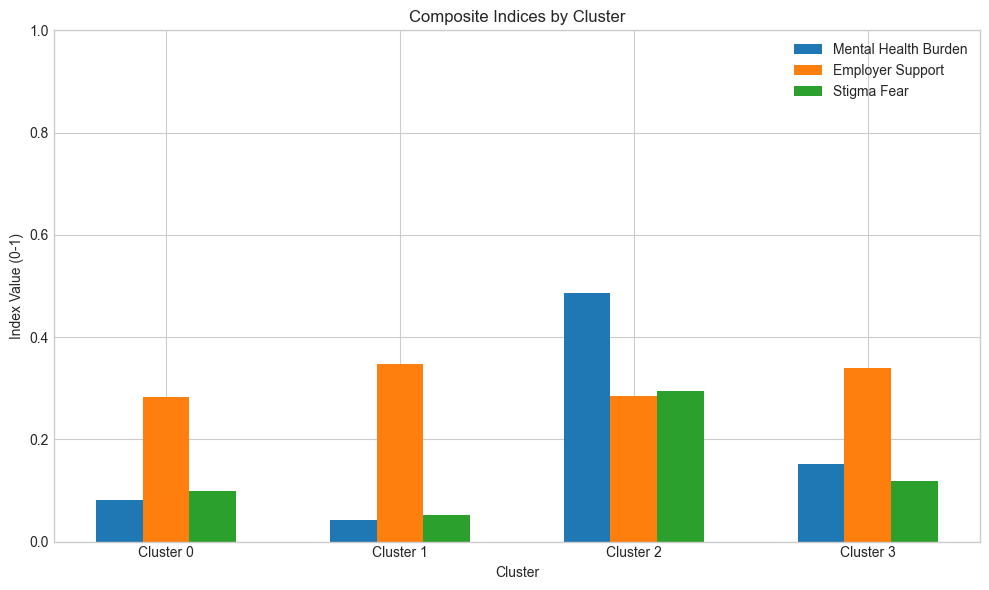

         idx_mental_health_burden  idx_employer_support  idx_stigma_fear
cluster                                                                 
0                           0.082                 0.283            0.099
1                           0.042                 0.347            0.053
2                           0.486                 0.285            0.294
3                           0.152                 0.340            0.119


In [13]:
idx_cols = [col for col in df.columns if col.startswith('idx_')]
print(f"Composite indices found: {idx_cols}")

if idx_cols:
    idx_means = df.groupby('cluster')[idx_cols].mean()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(n_clusters)
    width = 0.2
    
    for i, col in enumerate(idx_cols):
        label = col.replace('idx_', '').replace('_', ' ').title()
        ax.bar(x + i*width, idx_means[col], width, label=label)
    
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Index Value (0-1)')
    ax.set_title('Composite Indices by Cluster')
    ax.set_xticks(x + width * (len(idx_cols)-1) / 2)
    ax.set_xticklabels([f'Cluster {i}' for i in range(n_clusters)])
    ax.legend(loc='upper right')
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(f'../../plots/{RUN}/composite_indices_by_cluster.png', dpi=150)
    plt.show()
    
    print(idx_means.round(3))

## 4. Feature Category Analysis

In [14]:
feature_cols = [col for col in df.columns if col != 'cluster']
used_features = set()

def categorize(cols, keywords, exclude_keywords=None):
    result = []
    for col in cols:
        if col in used_features:
            continue
        if any(x in col for x in keywords):
            if exclude_keywords and any(x in col.lower() for x in exclude_keywords):
                continue
            result.append(col)
            used_features.add(col)
    return result

# Feature categories
demographic_features = categorize(feature_cols, ['age', 'gender', 'country_live', 'country_work'])
workplace_features = categorize(feature_cols, ['self-employed', 'employees', 'remotely', 'position_', 'tech company'])
mental_health_status = categorize(feature_cols, ['diagnosed_', 'currently have', 'in the past', 'family history', 'sought treatment', 'interferes with your work', 'medical professional'])
employer_support = categorize(feature_cols, ['provide mental health benefits', 'know the options', 'formally discussed', 'offer resources', 'anonymity protected', 'takes mental health as seriously', 'employer'])
attitudes_features = categorize(feature_cols, ['comfortable', 'willing', 'negative', 'hurt your career', 'bring up', 'observed', 'coworker', 'supervisor', 'team member', 'identified'])
composite_indices = categorize(feature_cols, ['idx_'])

uncategorized = [col for col in feature_cols if col not in used_features]

categories = {
    'Demographic': demographic_features,
    'Workplace': workplace_features,
    'Mental Health Status': mental_health_status,
    'Employer Support': employer_support,
    'Attitudes & Stigma': attitudes_features,
    'Composite Indices': composite_indices,
    'Other': uncategorized
}

print("Feature Categories:")
for cat_name, cat_features in categories.items():
    if cat_features:
        print(f"  {cat_name}: {len(cat_features)} features")

Feature Categories:
  Demographic: 14 features
  Workplace: 7 features
  Mental Health Status: 21 features
  Employer Support: 21 features
  Attitudes & Stigma: 22 features
  Composite Indices: 2 features
  Other: 4 features


## 5. Heatmap: Top Distinguishing Features

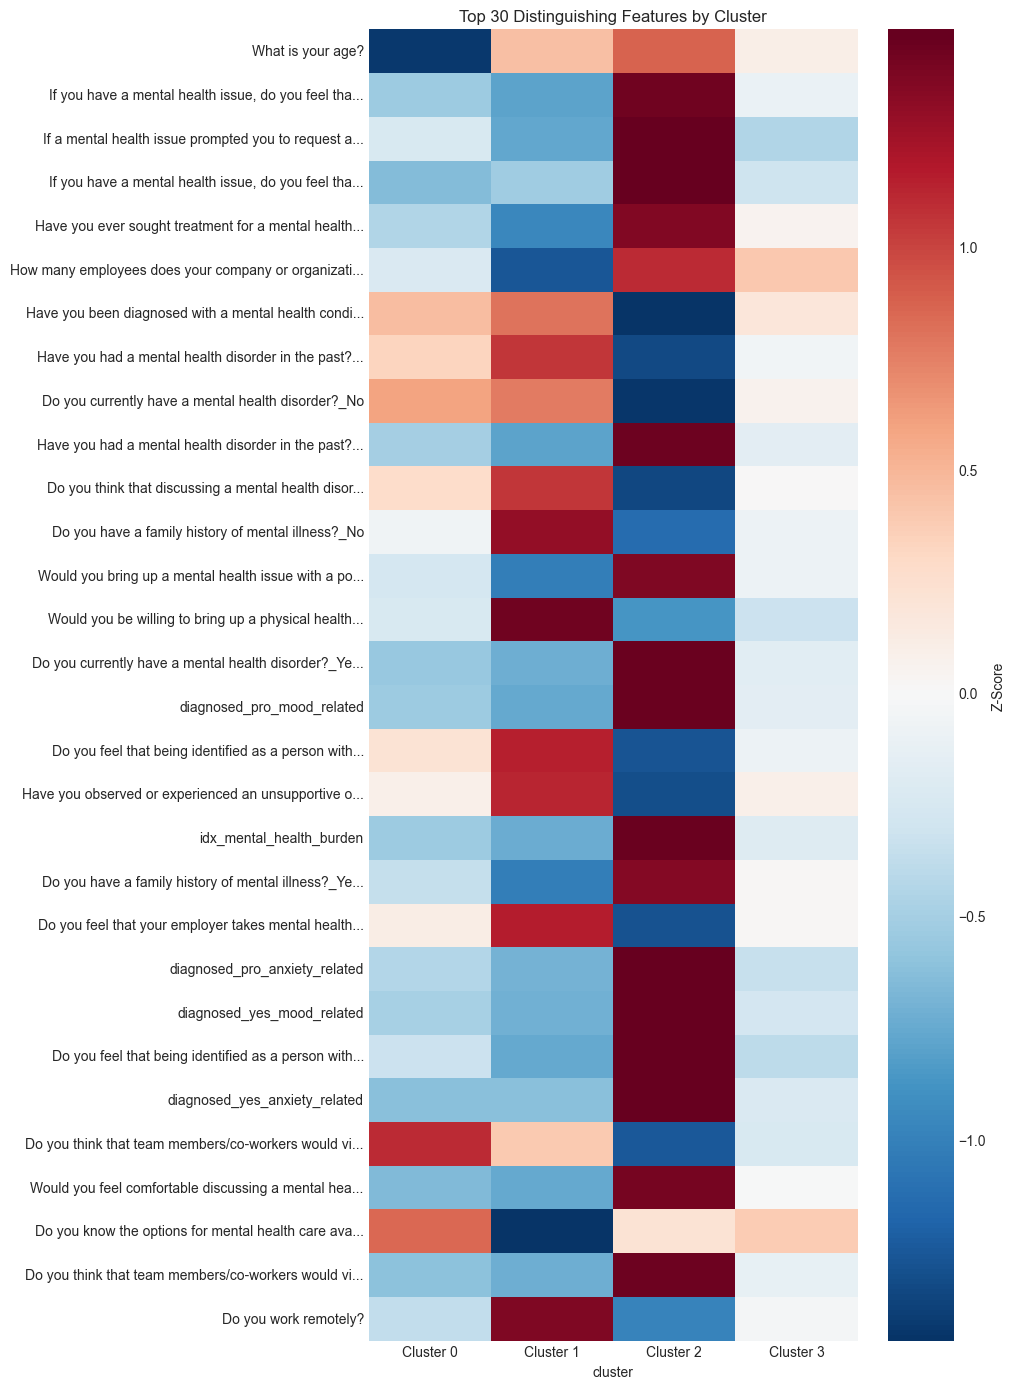

In [15]:
cluster_means = df.groupby('cluster')[feature_cols].mean()
cluster_means_norm = (cluster_means - cluster_means.mean()) / cluster_means.std()

top_features = cluster_means.var().nlargest(30).index.tolist()

fig, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(cluster_means_norm[top_features].T, cmap='RdBu_r', center=0,
            xticklabels=[f'Cluster {i}' for i in cluster_means.index],
            cbar_kws={'label': 'Z-Score'},
            yticklabels=[f[:50]+'...' if len(f) > 50 else f for f in top_features])
ax.set_title('Top 30 Distinguishing Features by Cluster')
plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/cluster_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Mental Health Analysis

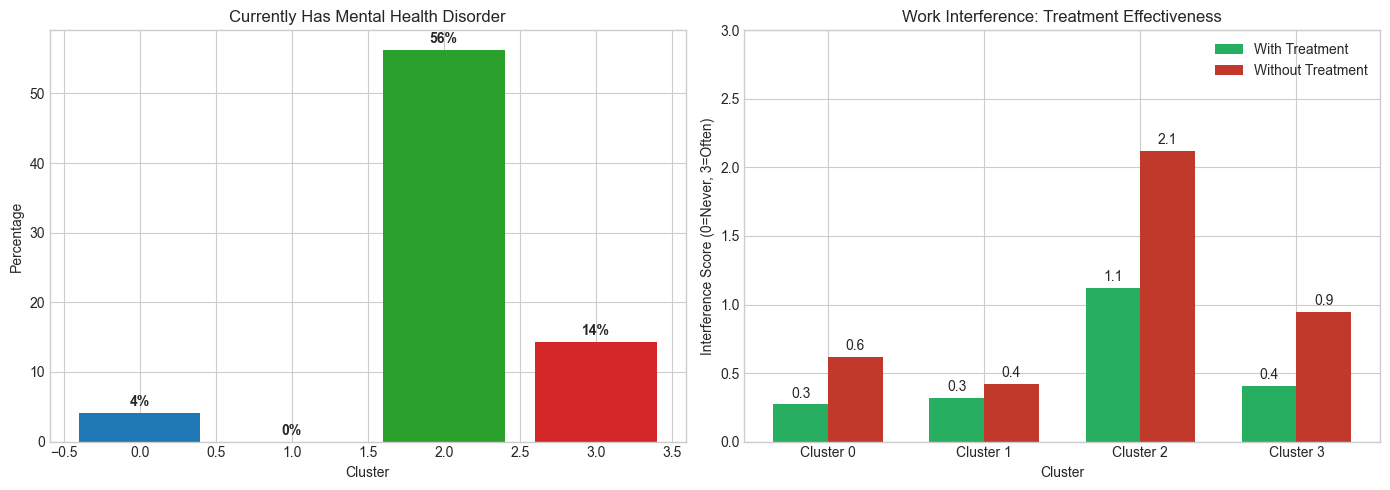

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mh_yes_col = [c for c in df.columns if 'currently have a mental health disorder?_Yes' in c]
if mh_yes_col:
    mh_status = df.groupby('cluster')[mh_yes_col[0]].mean() * 100
    bars = axes[0].bar(mh_status.index, mh_status.values, color=plt.cm.tab10(range(n_clusters)))
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Percentage')
    axes[0].set_title('Currently Has Mental Health Disorder')
    for bar in bars:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                     f'{bar.get_height():.0f}%', ha='center', fontweight='bold')

col_treated = [c for c in df.columns if 'interferes with your work when being treated' in c]
col_untreated = [c for c in df.columns if 'interferes with your work when NOT being treated' in c]

if col_treated and col_untreated:
    interference = df.groupby('cluster')[[col_treated[0], col_untreated[0]]].mean()
    x = np.arange(n_clusters)
    width = 0.35
    
    bars1 = axes[1].bar(x - width/2, interference[col_treated[0]], width, label='With Treatment', color='#27ae60')
    bars2 = axes[1].bar(x + width/2, interference[col_untreated[0]], width, label='Without Treatment', color='#c0392b')
    
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Interference Score (0=Never, 3=Often)')
    axes[1].set_title('Work Interference: Treatment Effectiveness')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f'Cluster {i}' for i in range(n_clusters)])
    axes[1].legend()
    axes[1].set_ylim(0, 3)
    
    for bar in list(bars1) + list(bars2):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                     f'{bar.get_height():.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/mental_health_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Workplace Attitudes: Openness vs. Stigma

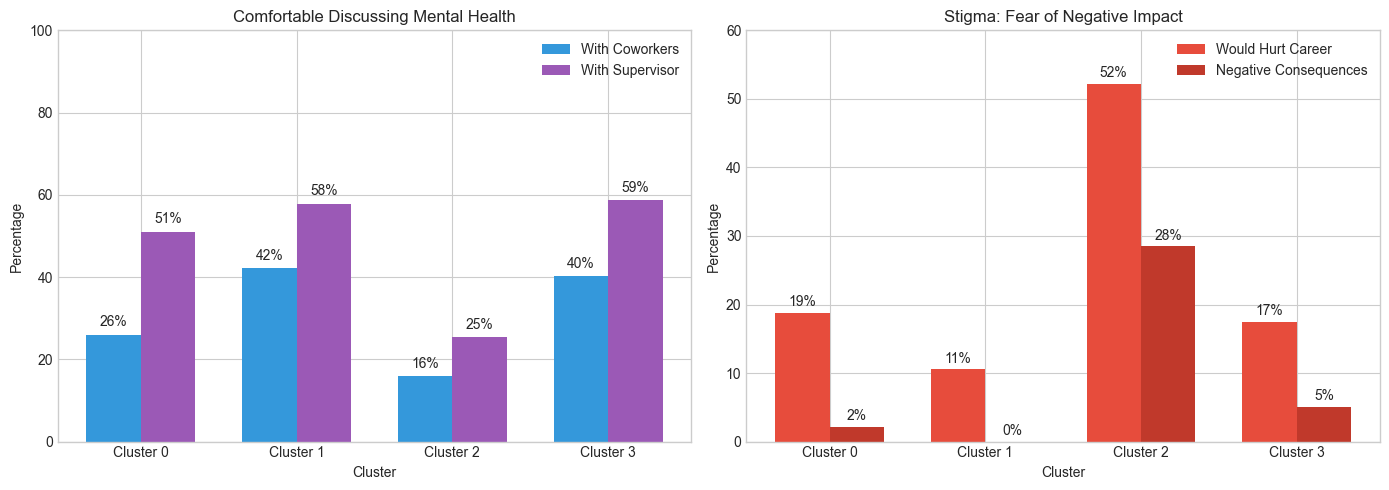

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Comfort discussing MH
comfort_coworkers = [c for c in df.columns if 'comfortable discussing a mental health disorder with your coworkers?_Yes' in c]
comfort_supervisor = [c for c in df.columns if 'comfortable discussing a mental health disorder with your direct supervisor' in c and '_Yes' in c]

if comfort_coworkers and comfort_supervisor:
    x = np.arange(n_clusters)
    width = 0.35
    
    cw_vals = df.groupby('cluster')[comfort_coworkers[0]].mean() * 100
    sv_vals = df.groupby('cluster')[comfort_supervisor[0]].mean() * 100
    
    bars1 = axes[0].bar(x - width/2, cw_vals.values, width, label='With Coworkers', color='#3498db')
    bars2 = axes[0].bar(x + width/2, sv_vals.values, width, label='With Supervisor', color='#9b59b6')
    
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Percentage')
    axes[0].set_title('Comfortable Discussing Mental Health')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f'Cluster {i}' for i in range(n_clusters)])
    axes[0].legend()
    axes[0].set_ylim(0, 100)
    
    for bar in list(bars1) + list(bars2):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                     f'{bar.get_height():.0f}%', ha='center', fontsize=10)

# 2. Stigma concerns
hurt_career = [c for c in df.columns if 'hurt your career?_Yes' in c]
neg_consequences = [c for c in df.columns if 'discussing a mental health disorder with your employer would have negative consequences?_Yes' in c]

if hurt_career and neg_consequences:
    x = np.arange(n_clusters)
    width = 0.35
    
    hc_vals = df.groupby('cluster')[hurt_career[0]].mean() * 100
    nc_vals = df.groupby('cluster')[neg_consequences[0]].mean() * 100
    
    bars3 = axes[1].bar(x - width/2, hc_vals.values, width, label='Would Hurt Career', color='#e74c3c')
    bars4 = axes[1].bar(x + width/2, nc_vals.values, width, label='Negative Consequences', color='#c0392b')
    
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Percentage')
    axes[1].set_title('Stigma: Fear of Negative Impact')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f'Cluster {i}' for i in range(n_clusters)])
    axes[1].legend()
    axes[1].set_ylim(0, 60)
    
    for bar in list(bars3) + list(bars4):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                     f'{bar.get_height():.0f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/workplace_attitudes.png', dpi=150, bbox_inches='tight')
plt.show()